In [85]:
import Pkg; Pkg.activate("..")
import QuadGK
using Distributions, Zygote, JuMP, Ipopt, NLopt, BSplines

include("util.jl")

# want to plot in R
using RCall
@rlibrary ggplot2
R"
suppressPackageStartupMessages({
library(tidyverse)
library(patchwork)
})
";

 Activating environment at `~/workspace/unplanned-sample-size-adaptation/Project.toml`


In [86]:
    α = 0.025; β = 0.2
 crit = quantile(Normal(), 1 - α)
  θ_1 = 0.4; τ = 0.2
prior = truncated(Normal(θ_1, τ), -0.5, 1)
 φ(θ) = pdf(prior, θ)
    n = 79.0; m = 26.0;

In [87]:
# parameterise the shape as bspline, should be more stable
function f(z, a, b, coefs) 
    @assert length(coefs) == 4 "coefs must be of length 4"
    Spline(BSplineBasis(4, range(a, b; length = 2)), coefs)(z)
end

f (generic function with 1 method)

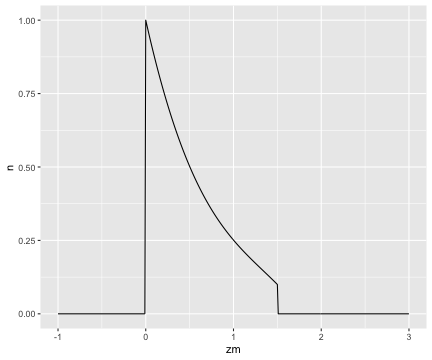

RObject{VecSxp}


In [88]:
 zm = collect(-1:0.01:3)
tmp = f.(zm, 0, 1.5, [[1, .33, .25, .1]])
R"
tibble(
    zm = $zm,
     n = $tmp
) %>%
ggplot() +
    aes(zm, n) +
    geom_line()
"

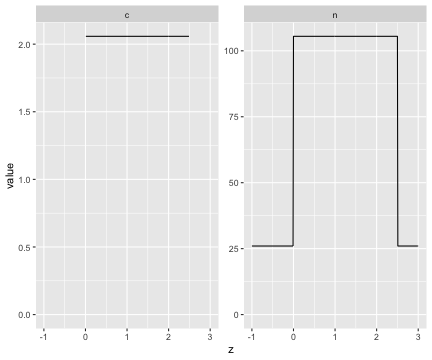

RObject{VecSxp}


In [89]:
function samplesize(z, n1, n2, cfut, ceff, β...)
    #@assert all(0 .<= β .<= 3) "coefficients must fulfill 0 <= β <= 3"
    # fix the first coefficient to 1 to make n2 identifiable
    n2 .* f(z, cfut, ceff, vcat(1, [β[i] for i in 1:length(β)])) .+ n1
end

function criticalvalue(z, c, cfut, ceff, β...)
    #@assert all(abs.(β) .<= 3) "coefficients must fulfill |β| <= 3"
    # fix the first coefficient to 1 to make c identifiable
    z <= cfut ? (return  1e9) : nothing
    z >= ceff ? (return -1e9) : nothing
    c .* f(z, cfut, ceff, vcat(1, [β[i] for i in 1:length(β)]))
end

 β_n_start = [1.0, 1.0, 1.0]
 β_c_start = [1.0, 1.0, 1.0]
cfut_start, ceff_start = 0, 2.5
n1_start, n2max_start = m, 1.5*(n - m)
crit_start = 1.05*crit

 z = collect(-1:0.01:3)
n_ = samplesize.(z, n1_start, n2max_start, cfut_start, ceff_start, β_n_start...)
c_ = criticalvalue.(z, crit_start, cfut_start, ceff_start, β_c_start...)
R"
tibble(
    z = $z,
    n = $n_,
    c = $c_ %>% if_else(abs(.) <10, ., NA_real_)
) %>%
pivot_longer(-z, names_to = 'type', values_to = 'value') %>%
filter(complete.cases(value)) %>% 
ggplot() +
    aes(z, value) +
    geom_line() +
    scale_y_continuous(limits = c(0, NA)) +
    facet_wrap(~type, scales = 'free_y')
"

In [90]:
function ess(n1, n2max, cfut, ceff, β_n...)
    futility = n1 * (1 - integrate(z -> marginal_pdf.(z, n1, φ), cfut))
    efficacy = n1 * integrate(z -> marginal_pdf.(z, n1, φ), ceff)
    stagetwo = integrate(z -> samplesize(z, n1, n2max, cfut, ceff, β_n...) * marginal_pdf.(z, n1, φ), cfut, ceff)
    futility + stagetwo + efficacy
end

@show ess(n1_start, n2max_start, cfut_start, ceff_start, β_n_start...);

ess(n1_start, n2max_start, cfut_start, ceff_start, β_n_start...) = 69.76495566162579


In [91]:
function mtoer(n1, n2max, crit, cfut, ceff, coefs...) 
    β_n = coefs[1:3]
    β_c = coefs[4:6]
    stagetwo = integrate(
        z -> CP(z, samplesize(z, n1, n2max, cfut, ceff, β_n...), n1, criticalvalue(z, crit, cfut, ceff, β_c...), 0) * pdf(Normal(), z),
        cfut, ceff
    )
    efficacy = 1 - cdf(Normal(), ceff)
    stagetwo + efficacy
end

β_combined_start = vcat(β_n_start, β_c_start)

@show mtoer(n1_start, n2max_start, crit_start, cfut_start, ceff_start, β_combined_start...);

mtoer(n1_start, n2max_start, crit_start, cfut_start, ceff_start, β_combined_start...) = 0.022883711809156524


In [92]:
function ep(n1, n2max, crit, cfut, ceff, coefs...) 
    β_n = coefs[1:3]
    β_c = coefs[4:6]
    stagetwo = integrate(
        z -> PP(z, samplesize(z, n1, n2max, cfut, ceff, β_n...), n1, criticalvalue(z, crit, cfut, ceff, β_c...), φ) * cmarginal_pdf(z, n1, φ),
        cfut, ceff
    )
    efficacy = integrate(z -> cmarginal_pdf(z, n1, φ), ceff)
    stagetwo + efficacy
end

@show ep(n1_start, n2max_start, crit_start, cfut_start, ceff_start, β_combined_start...);

ep(n1_start, n2max_start, crit_start, cfut_start, ceff_start, β_combined_start...) = 0.8216545302337543


In [96]:
mdl = Model(
    optimizer_with_attributes(
        Ipopt.Optimizer, 
        "print_level" => 4,
        "nlp_scaling_method" => "gradient-based",
        "nlp_scaling_max_gradient" => 100.0,
        "nlp_scalingφlue" => 1e-4,
        "tol" => 1e-5,
        "max_cpu_time" => 300.0,
        "max_iter" => 10000
    )
)

#register(mdl, :samplesize, 4 + kn + 1, samplesize; autodiff = true)
#register(mdl, :criticalvalue, 4 + kc + 1, criticalvalue; autodiff = true)
register(mdl, :ess, 4 + 3, ess; autodiff = true)
register(mdl, :mtoer, 5 + 3 + 3, mtoer; autodiff = true)
register(mdl, :ep,    5 + 3 + 3, ep; autodiff = true)

@variable(mdl, 
    0 <= β_n[i=1:3] <= 3, 
    start = 1.0
)
@variable(mdl, 
    n1_start <= n2max <= 4*n1_start, 
    start = n2max_start
)
@variable(mdl, 
    1 <= β_c[i=1:3] <= 5, 
    start = 1.0
)
@expression(mdl, coefs, vcat(β_n, β_c))
@variable(mdl, 
    10 <= n1 <= n,
    start = m
)
@variable(mdl, 
    crit, 
    start = crit_start
)
@variable(mdl, 
    -10 <= cfut <= crit_start/2, 
    start = cfut_start
)
@variable(mdl, 
    crit_start/2 <= ceff <= 10, 
    start = ceff_start
)
@constraint(mdl, ceff - cfut >= 0.1)

@NLobjective(mdl, Min, ess(n1_start, n2max, cfut, ceff, β_n...))
@NLconstraint(mdl, mtoer(n1_start, n2max, crit, cfut, ceff, coefs...) <= 0.025)
@NLconstraint(mdl, ep(n1_start, n2max, crit, cfut, ceff, coefs...) >= 0.8)
#@NLconstraint(mdl, samplesize(0 + .1, 0, 3, m, β_n...) >= m + 5)
#@NLconstraint(mdl, samplesize(3 - .1, 0, 3, m, β_n...) >= m + 5)

print(mdl)

Min ess(26.0, n2max, cfut, ceff, β_n[1], β_n[2], β_n[3])
Subject to
 ceff - cfut ≥ 0.1
 β_n[1] ≥ 0.0
 β_n[2] ≥ 0.0
 β_n[3] ≥ 0.0
 n2max ≥ 26.0
 β_c[1] ≥ 1.0
 β_c[2] ≥ 1.0
 β_c[3] ≥ 1.0
 n1 ≥ 10.0
 cfut ≥ -10.0
 ceff ≥ 1.0289810918835303
 β_n[1] ≤ 3.0
 β_n[2] ≤ 3.0
 β_n[3] ≤ 3.0
 n2max ≤ 104.0
 β_c[1] ≤ 5.0
 β_c[2] ≤ 5.0
 β_c[3] ≤ 5.0
 n1 ≤ 79.0
 cfut ≤ 1.0289810918835303
 ceff ≤ 10.0
 mtoer(26.0, n2max, crit, cfut, ceff, β_n[1], β_n[2], β_n[3], β_c[1], β_c[2], β_c[3]) - 0.025 ≤ 0
 ep(26.0, n2max, crit, cfut, ceff, β_n[1], β_n[2], β_n[3], β_c[1], β_c[2], β_c[3]) - 0.8 ≥ 0


In [97]:
JuMP.optimize!(mdl)

Total number of variables............................:       11
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        3
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1


Number of Iterations....: 2049

                                   (scaled)                 (unscaled)
Objective...............:   5.4324649463495845e+01    5.4324649463495845e+01
Dual infeasibility......:   1.2956296587151201e+02    1.2956296587151201e+02
Constraint violation....:   8.1106209206617767e-03    8.1106209206617767e-03
Complementarity.........:   7.2093820238178410e-02    7.2093820238178410e-02
Overall NLP

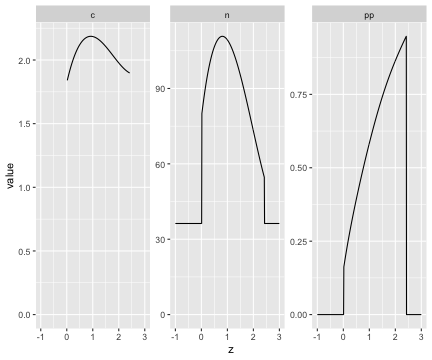

RObject{VecSxp}


In [100]:
  z = collect(-1:0.01:3)
 n_ = samplesize.(z, value(n1), value(n2max), value(cfut), value(ceff), value.(β_n)...)
 c_ = criticalvalue.(z, value(crit), value(cfut), value(ceff), value.(β_c)...)
pp_ = PP.(z, n_, value(n1), c_, φ)
R"
tibble(
     z = $z,
     n = $n_,
     c = $c_ %>% if_else(abs(.) <10, ., NA_real_),
    pp = $pp_
) %>%
pivot_longer(-z, names_to = 'type', values_to = 'value') %>%
filter(complete.cases(value)) %>% 
ggplot() +
    aes(z, value) +
    geom_line() +
    scale_y_continuous(limits = c(0, NA)) +
    facet_wrap(~type, scales = 'free_y')
"

In [79]:
@show ess(value(n1), value(n2max), value(cfut), value.(ceff), value.(β_n)...);
@show mtoer(value(n1), value(n2max), value(crit), value(cfut), value(ceff), value.(coefs)...);
@show ep(value(n1), value(n2max), value(crit), value(cfut), value(ceff), value.(coefs)...);

ess(value(n1), value(n2max), value(cfut), value.(ceff), value.(β_n)...) = 64.15067584345107
mtoer(value(n1), value(n2max), value(crit), value(cfut), value(ceff), value.(coefs)...) = 0.02602326525951238
ep(value(n1), value(n2max), value(crit), value(cfut), value(ceff), value.(coefs)...) = 0.832927015218057


In [104]:
value(ceff)

2.420671778929277

In [105]:
ceff_start

2.5